In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
true = True
false = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Сохранять ли графические результаты обучения и куда
name_of_image = 'Presentations/22_04_13/batch_size_test_114_400'
save_figures_general = False
save_figures_dense = False
save_figures_conv = False

# Название файла откуда считываются обработанные данные
# name_of_file = 'PD110_time_no_empty'                                          # Основной с распределенными столкновениями, время - прямое
name_of_file = 'PD114_time_inv_0coord'                                      # Основной столкновния в нуле, время - обратное  


include_coord_feature = False
only_time_feature = False

number_of_groups = 2                # Количество интервалов на которые делятся прицельные параметры
number_of_epoches_lin = 150         # Количество эпох в обучении полносвязной нейросети
number_of_epoches_conv = 150        # Количество эпох в обучении сверточной нейросети
batch_size = 400                    # Размер батча
threshold = 5

# Задание весов для двух классов
loss_weights = torch.tensor([1.0, 0.162]).to(device)        # Подходит для границы в 5 фм
# loss_weights = torch.tensor([1.0, 0.33]).to(device)        # Подходит для границы в 7 фм
# loss_weights = torch.tensor([1.0, 1.0]).to(device)        # Без балансирования классов

norms = [200, 32, 6]

input_data = []
with open('data/' + name_of_file + '.dat', 'r') as inpf: 
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    maximum_hits = int(s[2])
    n_lines = int(s[4])
    if only_time_feature:
        n_lines = 1
    number_of_features = n_lines * maximum_hits
    if include_coord_feature:
        number_of_features += 1
    print(l)

    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        coord = float(s[1])
        phi_b = float(s[2])


        n = 0     
        for digit in s[3:]:
             
            if n < maximum_hits:
                features.append(float(digit) / norms[0])
            elif only_time_feature:
                break
            elif n < maximum_hits * 2:
                features.append(float(digit) / norms[1])
            else:
                features.append(float(digit) / norms[2])
            n += 1
            '''
            features.append(float(digit))
            '''
        if include_coord_feature:    
            features.append(coord)
        input_data.append([b, coord, features])



if include_coord_feature:
    number_of_features += 1

cuda:0
Maximum hits: 60 Lines: 3



In [2]:
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels[idx]
        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}

        return sample


# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    
    # define borders of segments
    for i in range(groups):   
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=int)
    incr = 0
    
    # iterate over all (not sorted) labels and encode them
    for elem in labels:   
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()


def encode_binary(labels_arr: np.ndarray, border: float) -> np.ndarray:
    result_arr = np.zeros_like(labels_arr)
    for ind in range(len(labels_arr)):
        if labels_arr[ind] > border:
            result_arr[ind] = 1
    return result_arr



np.random.shuffle(input_data)
input_sorted = sorted(input_data, key=lambda x: (x[0]))
    
features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), 1))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    labels[incr] = np.array(elem[0])
    coordinates[incr] = np.array(elem[1])
    features[incr] = np.array(elem[2])
    incr += 1
    

# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets
print("Были прицельные параметры: \n {}".format(labels[:6]))
labels_encoded_binary = encode_binary(labels, border=threshold)
print("Закодированы в интервалы: \n {}".format(labels_encoded_binary[:6]))
train_labels = torch.flatten(torch.tensor(labels_encoded_binary[:size_of_training_set])).to(device)
test_labels = (torch.flatten(torch.tensor(labels_encoded_binary[size_of_training_set:]))).type(torch.LongTensor).to(device)
big_test_labels = np.count_nonzero(test_labels.to(device='cpu'))
amount_of_test_labels =  [size_of_test_set - big_test_labels, big_test_labels]
print(amount_of_test_labels)


train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)

print('Train shape: {}'.format(train_features.shape))
print('Test shape: {}'.format(test_features.shape))

Были прицельные параметры: 
 [[13.88 ]
 [14.075]
 [ 7.44 ]
 [ 9.344]
 [12.504]
 [12.929]]
Закодированы в интервалы: 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[5704, 35433]
Train shape: torch.Size([164544, 180])
Test shape: torch.Size([41137, 180])


In [3]:
# Linear Fully connected network. 
# Convolutional - three blocks below

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 256)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 128)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = self.lin2.out_features, out_features = 64)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        self.lin4 = nn.Linear(in_features = self.lin3.out_features, out_features = 32)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 16, out_features = 12)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 12, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = self.lin4.out_features, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t


In [4]:
# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features)
teDS = DatasetNN(test_labels, test_features)
trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
teDL = torch.utils.data.DataLoader(trDS, batch_size=len(teDS))

net = Network().to(device)
print(net)
optimizer = optim.Adam(net.parameters(), lr=0.001)



total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []

# Learning process
for epoch in range(number_of_epoches_lin):
    total_correct = 0
    t_loss = 0
    for batch in trDL:
        batch_labels = (batch['label']).type(torch.LongTensor).to(device)
        batch_features = batch['feature'].to(device)

        predicted = net(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += (loss.item() * batch_size/len(trDS))
        total_correct += get_correct_predictions(predicted, batch_labels)

    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
        .format(epoch, t_loss, total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(t_loss)
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Network(
  (lin1): Linear(in_features=180, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Epoch:    0 |---> loss is 0.4521458107, total correct predictions: 133319, its 81.023%
Epoch:    1 |---> loss is 0.4278481142, total correct predictions: 140289, its 85.259%
Epoch:    2 |---> loss is 0.4243596631, total correct predictions: 141449, its 85.964%
Epoch:    3 |---> loss is 0.4210148933, total correct predictions: 142701, its 86.725%
Epoch:    4 |---> loss is 0.4181028138, total correct predictions: 143631, its 87.290%
Epoch:    5 |---> loss is 0.4149259035, total correct predictions: 144565, its 87.858%
Epoch:    6 |---> loss is 0.4123270771, total correct predictions: 145231, its 88.263%
Epoch:    7 |---> loss is 0.4101557596, total correct predictions: 14575

Test accuracy is 90.91%
tensor([[ 5096.,   608.],
        [ 3133., 32300.]])
tensor([[0.8934, 0.1066],
        [0.0884, 0.9116]])


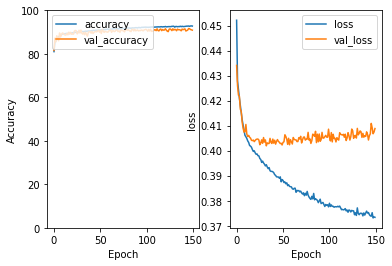

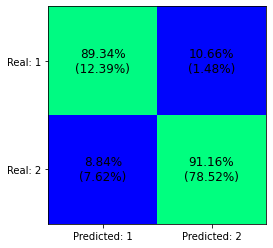

In [5]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    test_accuracy = test_correct_predictions * 100 /test_features.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy))
    
    with open('some_results.txt', 'a') as batch_results:
        batch_results.write('{}  lin: | {:7d}     | {:7d}     | {:7.2f}  |'.format(name_of_file, batch_size, number_of_epoches_conv, test_accuracy))
        
    # Creating of confusion matrix
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    # horizontal axis - predicted, vertical - true
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.float)      
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    confusion_matrix_normed = torch.clone(confusion_matrix)
    for i in range(confusion_matrix.shape[0]):
        norm = confusion_matrix[i][0].item() + confusion_matrix[i][1].item()
        confusion_matrix_normed[i] /=   norm
    print(confusion_matrix)
    print(confusion_matrix_normed)
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_normed, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cell_label = str(round(confusion_matrix_normed[i][j].item()*100, 2)) + '%\n(' + str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%)'
            text = ax.text(j, i, cell_label, ha="center", va="center", size=12)
            # text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/amount_of_test_labels[i], 2)) + '%', ha="center", va="center", size=12)
    if save_figures_dense:
        plt.savefig((name_of_image + '_dense_binary'), dpi=300)


In [6]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(n_lines, 40), stride=(1, 40))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        
        
        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int((maximum_hits)/2) - 2), out_features=128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features=self.lin2.out_features, out_features=32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=self.lin3.out_features, out_features=8)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=self.lin3.out_features, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, self.conv1.out_channels*(int((maximum_hits)/2) - 2))))
        # t = F.relu(self.lin1(t.reshape(-1, self.conv1.out_channels*(int((maximum_hits)/40)))))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t


In [7]:
# В этом блоке - сам процесс обучения
net_c = NetworkConv().to(device)
print(net_c)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.001, weight_decay=0.0001)

# Here define weights for loss contribution of segments
# loss_weights_c = torch.ones(number_of_groups)
# loss_weights_c = torch.tensor([1.0, 0.125]).to(device)
# print(loss_weights_c)
total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    total_correct = 0
    t_loss = 0.0
    for batch in trDL:
        batch_labels = batch['label'].type(torch.LongTensor).to(device)
        batch_features = batch['feature'].to(device)

        predicted = net_c(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights)
        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()
        t_loss += (loss.item() * batch_size / len(trDS))
        total_correct += get_correct_predictions(predicted, batch_labels)
    
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, t_loss, total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)
        total_accuracy_c.append(total_correct*100/train_features.shape[0])
        
        test_preds = net_c(test_features)
        total_val_loss_c.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

NetworkConv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 6), stride=(1, 2))
  (lin1): Linear(in_features=448, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
Epoch:    0 |---> loss is 0.4827781547, total correct predictions: 121369, its 73.761%
Epoch:    1 |---> loss is 0.4363822633, total correct predictions: 137023, its 83.274%
Epoch:    2 |---> loss is 0.4295374084, total correct predictions: 139543, its 84.806%
Epoch:    3 |---> loss is 0.4274686038, total correct predictions: 140393, its 85.322%
Epoch:    4 |---> loss is 0.4252442571, total correct predictions: 141121, its 85.765%
Epoch:    5 |---> loss is 0.4237893457, total correct predictions: 141342, its 85.899%
Epoch:    6 |---> loss is 0.4222594325, total correct predictions: 141946, its 86.266%
Epoch:    7 |---> loss is 0.4216976610, total correct predictions: 1422

37190
Test accuracy is 90.41%
tensor([[ 5251.,   453.],
        [ 3494., 31939.]])
tensor([[ 5251.,   453.],
        [ 3494., 31939.]])
tensor([[0.9206, 0.0794],
        [0.0986, 0.9014]])


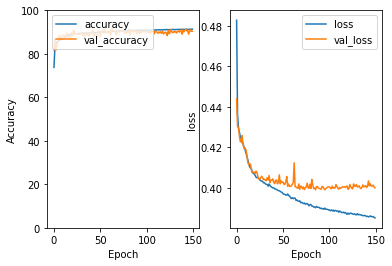

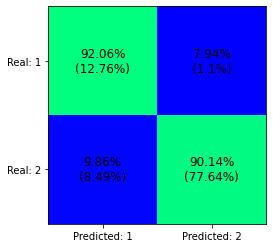

In [8]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels)
    print(test_correct_predictions_c)
    test_accuracy_c = test_correct_predictions_c * 100 /test_features.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy_c))
    
    with open('some_results.txt', 'a') as batch_results:
        batch_results.write('          conv: | {:7d}     | {:7d}     | {:7.2f}  |\n'.format(batch_size, number_of_epoches_conv, test_accuracy_c))

    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.float)      
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    print(confusion_matrix_c)
    confusion_matrix_c_normed = torch.clone(confusion_matrix_c) 

    for i in range(confusion_matrix_c.shape[0]):
        norm = confusion_matrix_c[i][0].item() + confusion_matrix_c[i][1].item()
        confusion_matrix_c_normed[i] /=   norm
    print(confusion_matrix_c)
    print(confusion_matrix_c_normed)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c_normed, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            cell_label = str(round(confusion_matrix_c_normed[i][j].item()*100, 2)) + '%\n(' + str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0], 2)) + '%)'
            # text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)
            text = ax.text(j, i, cell_label, ha="center", va="center", size=12)
    if save_figures_conv:
        plt.savefig((name_of_image + '_conv_binary'), dpi=300)

In [9]:
s = len(train_features)
time_test_features = train_features[:s].to(device='cuda:0')
start_time = time.time()
res = net_c(time_test_features)
res_time = time.time() - start_time
print("Time taken: {} s, for {} events".format(res_time, s))
print("It's {} s per event".format(res_time/s))

Time taken: 0.004602670669555664 s, for 164544 events
It's 2.797227896219652e-08 s per event
